### Assignment 6.1: Upwelling near Peru
The ocean region near Peru is known for its upwelling, causing the rise of nutrient-rich bottom water to the surface and a subsequently flourishing ecosystem. Hence, it is an important region for wildlife and for the fishery industry. 

We explored this area with an ADCP device onboard the "virtual ship". It measured zonal and meridional velocities up to 500 metres depth. In this assignment you will process this data and interpret the results with your knowledge of wind-induced effects on ocean circulation.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cmocean
import numpy as np
from geopy import distance

__a)__ Make a plot of the ship's trajectory. Check that it runs perpendicular to the coast of Peru.

Text(0.5, 1.0, 'Peru adcp')

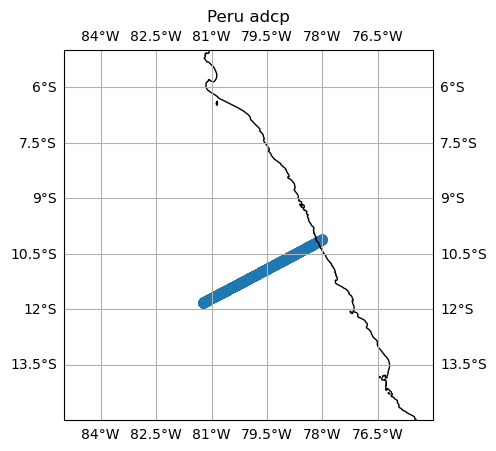

In [2]:
# Answer
peru = xr.open_zarr('Peru_adcp.zarr').compute()

# for convenience, define z positive upward
zu = np.unique(-peru.z, axis=1).squeeze() # convert z to 1D and positive upward
peru = peru.assign_coords({'z':('trajectory',zu)}).sortby('z')

# plot track
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(peru.lon, peru.lat, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent((-85,-75,-15,-5))
ax.set_title('Peru adcp')

__b)__ Calculate the distance from each measurement to the coast and add it as variable to the dataset.

In [3]:
# Answer
peru_surf = peru.isel(trajectory=0).compute()
d = xr.zeros_like(peru_surf.lon)
lon0,lat0 = peru_surf.lon.data[-1], peru_surf.lat.data[-1]
for ob,(lon,lat) in enumerate(zip(peru_surf.lon.data,peru_surf.lat.data)):
    d[ob] = distance.distance((lon,lat),(lon0,lat0)).m
peru['s'] = -d.assign_attrs({
    'long_name':'distance to coast','units':'m','positive':'shoreward'})
peru = peru.set_coords('s').sortby('s')
print(f"max distance: {abs(peru.s.min()).data/1000:.2f} km")

max distance: 362.62 km


__c)__ Calculate and plot the velocity components parallel and perpendicular to the coast.

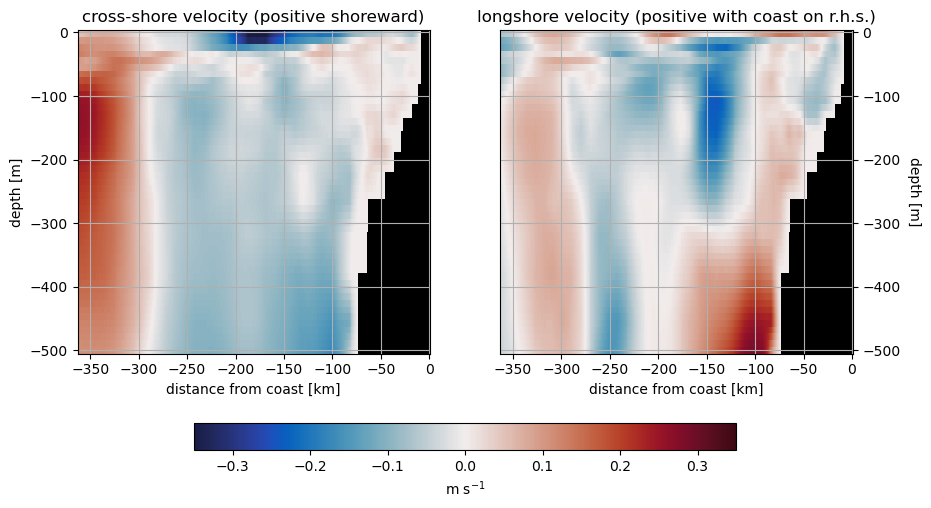

In [4]:
# Answer

# calculations
dlon = np.deg2rad(peru_surf.lon.differentiate('obs'))
dlat = np.deg2rad(peru_surf.lat.differentiate('obs'))
lat = np.deg2rad(peru_surf.lat)
alpha = np.arctan(dlat/(dlon*np.cos(lat))).mean('obs') # cruise direction angle
Ucross = np.cos(alpha)*peru.U + np.sin(alpha)*peru.V # cross-shore vel
Ulong = -np.sin(alpha)*peru.U + np.cos(alpha)*peru.V  # long-shore vel
peru['Ucross'] = Ucross.assign_attrs({'long_name':'cross-shore velocity','units':'m s-1'})
peru['Ulong'] = Ulong.assign_attrs({'long_name':'longshore velocity','units':'m s-1'})

# figure settings
fig = plt.figure(figsize=(10,6))
norm = mcolors.CenteredNorm(halfrange=0.35)
cmap = cmocean.cm.balance
landmask = xr.where(((peru.U==0) & (peru.V==0)), 1, np.nan)
S = peru.s.broadcast_like(peru.lon)

# cross-shore velocity plot
ax1 = fig.add_subplot(121)
p = ax1.pcolormesh(S/1000, peru.z, peru.Ucross, norm=norm, cmap=cmap)
ax1.pcolormesh(S/1000, peru.z, landmask, cmap='binary_r')
ax1.set_ylabel('depth [m]')
ax1.set_xlabel('distance from coast [km]')
ax1.set_title('cross-shore velocity (positive shoreward)')
ax1.grid()

# alongshore velocity plot
ax2 = fig.add_subplot(122, sharey=ax1)
ax2.yaxis.tick_right()
p2 = ax2.pcolormesh(S/1000, peru.z, peru.Ulong, norm=norm, cmap=cmap)
ax2.pcolormesh(S/1000, peru.z, landmask, cmap='binary_r')
ax2.set_ylabel('depth [m]', rotation=270, labelpad=15)
ax2.set_xlabel('distance from coast [km]')
ax2.set_title('longshore velocity (positive with coast on r.h.s.)')
ax2.yaxis.set_label_position('right')
ax2.grid()
fig.colorbar(p, ax=[ax1,ax2], shrink=0.7, orientation='horizontal',
             label=r'm s$^{-1}$')

Assuming constant density and no velocity variations in the longshore direction, the continuity equation may be written 
$$\frac{\partial u_{cross}}{\partial s} + \frac{\partial w}{\partial z} = 0$$  
where $u_{cross}$ is the cross-shore velocity, $s$ the shoreward distance, $w$ the vertical velocity and $z$ the depth (upward positive).  

__d)__ Starting from the surface downward, integrate the continuity equation to find the vertical velocity. Explain what you see. 

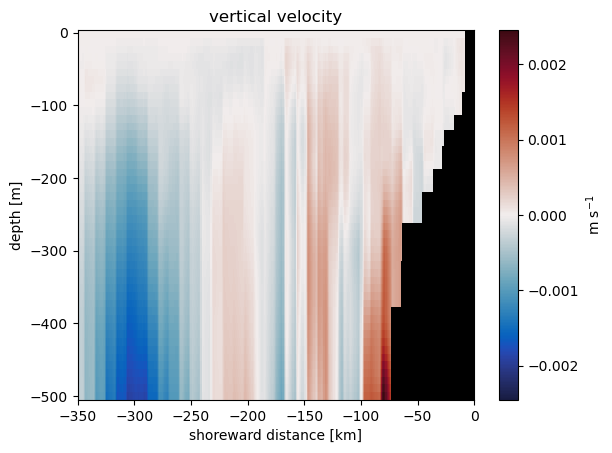

In [5]:
# Answer
peru_d = peru.sortby('z', ascending=False) # sort downward

# # compute dwdz - easy central difference method
# dwdz = -peru_d.Ucross.differentiate('s')

# compute dwdz - central difference using interpolated values at cell edges
# slightly more accurate
landfilter = xr.where(((peru_d.U==0) & (peru_d.V==0)), 0, 1) # 0 in land, 1 in ocean
Ucrossi = peru_d.Ucross.interp(obs=peru_d.obs-0.5) # U at cell boundaries (toward ocean)
Ucrossi = Ucrossi * landfilter.data
dUcrossds = Ucrossi.diff('obs') / Ucrossi.s.diff('obs')
dwdz = -dUcrossds

# # integrate dwdz
peru['w'] = dwdz.cumulative_integrate('z')

# plot
ax = plt.axes()
S,Z = xr.broadcast(peru.s/1000, peru.z)
w = ax.pcolormesh(S, Z, peru.w.T, norm=mcolors.CenteredNorm(), cmap=cmap)
ax.pcolormesh(S, Z, landmask.T, cmap='binary_r')
plt.title('vertical velocity')
plt.ylabel('depth [m]')
plt.xlabel('shoreward distance [km]')
plt.xlim([-350,0])
plt.colorbar(w, label=r'm s$^{-1}$')

Answer: the south-easterly winds near Peru create Ekman transport away from the coast (to the left of the wind direction in the SH), leading to an SSH-gradient directed off the coast. This SSH-gradient results in a pressure gradient force directed toward the coast and a longshore geostrophic current with the coast on its r.h.s.. Due to friction at the bottom, the coriolis force of the current decreases and gives rise to a cross-shore current that is pushed up against the topography. This explains the column of water having positive vertical velocity near the land boundary.  

There are limitations to this point of view. The longshore geostrophic current does not show up at all depths near the coast. Likely, some baroclinic effects are important as well. Besides, the vertical velocity is derived assuming incompressibility and no longshore variations in longshore flow. Especially the last statement may lead to inaccurate results. Besides, ocean models often use "shaved cells" near the topographic boundary of reduced thickness. This needs to be accounted for before calculating water fluxes.